# Análisis de Entrada II: herramientas adicionales

Prof. Tito Homem-de-Mello

## Retomemos el problema de energía estudiado anteriormente

In [ ]:
install.packages('fitdistrplus')
install.packages('ggplot2')
install.packages('nortest')
install.packages('tidyr')
install.packages('data.table')
install.packages('lubridate')

In [1]:
library(fitdistrplus)
library(data.table)
library(ggplot2)
library(tidyr)
library(lubridate)

Loading required package: MASS

Loading required package: survival


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
#Ajustes para gráficos via ggplot
mytheme <- theme(plot.title = element_text(size = 22),
                    axis.title.y=element_text(size = 20),
                    axis.text.y=element_text(size = 15),
                    axis.title.x=element_text(size = 20),
                    axis.text.x=element_text(size = 15),
                    legend.position="bottom",
                    legend.text=element_text(size = 15),
                    legend.title=element_text(size = 15))

In [3]:
energy <- fread("energy_dataset.csv")
head(energy)

time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,⋯,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2014-12-31 23:00:00,447,329,0,4844,4821,162,0,0,0,⋯,196,0,6378,17,NA,6436,26118,25385,50.10,65.41
2015-01-01 00:00:00,449,328,0,5196,4755,158,0,0,0,⋯,195,0,5890,16,NA,5856,24934,24382,48.10,64.92
2015-01-01 01:00:00,448,323,0,4857,4581,157,0,0,0,⋯,196,0,5461,8,NA,5454,23515,22734,47.33,64.48
2015-01-01 02:00:00,438,254,0,4314,4131,160,0,0,0,⋯,191,0,5238,2,NA,5151,22642,21286,42.27,59.32
2015-01-01 03:00:00,428,187,0,4130,3840,156,0,0,0,⋯,189,0,4935,9,NA,4861,21785,20264,38.41,56.04
2015-01-01 04:00:00,410,178,0,4038,3590,156,0,0,0,⋯,188,0,4618,4,NA,4617,21441,19905,35.72,53.63


In [12]:
data7<-energy[year(time)<=2018 &
                month(time)==7 & mday(time)<31,
             .(anio=year(time),  
              dia= mday(time), 
               hora= hour(time),
                solar=`forecast solar day ahead`,
                eol=`forecast wind onshore day ahead`,
                dem=`total load forecast`,
                precio=`price actual`,
                time= as.POSIXct(time)) ]  #Guarda el campo "time" para uso posterior

test7<-energy[year(time)==2018 &
                month(time)==7 & mday(time)==31,
             .(anio=year(time),  
              dia= mday(time), 
               hora= hour(time),
                solar=`forecast solar day ahead`,
                eol=`forecast wind onshore day ahead`,
                dem=`total load forecast`)]


price7_test <- energy[year(time)==2018 &
                month(time)==7 & mday(time)==31,.(precio=`price actual`)]




### Hicimos un pronóstico via regresión

In [6]:
mod7<-with(data7,lm(formula=precio ~ hora+eol+dem))
summary(mod7)


Call:
lm(formula = precio ~ hora + eol + dem)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.5365  -8.1625   0.0913   7.4602  27.5398 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.564e+01  1.290e+00  27.635  < 2e-16 ***
hora         2.059e-01  2.887e-02   7.132 1.25e-12 ***
eol         -1.636e-03  7.581e-05 -21.583  < 2e-16 ***
dem          1.002e-03  4.276e-05  23.431  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.747 on 2876 degrees of freedom
Multiple R-squared:  0.3238,	Adjusted R-squared:  0.3231 
F-statistic: 459.1 on 3 and 2876 DF,  p-value: < 2.2e-16


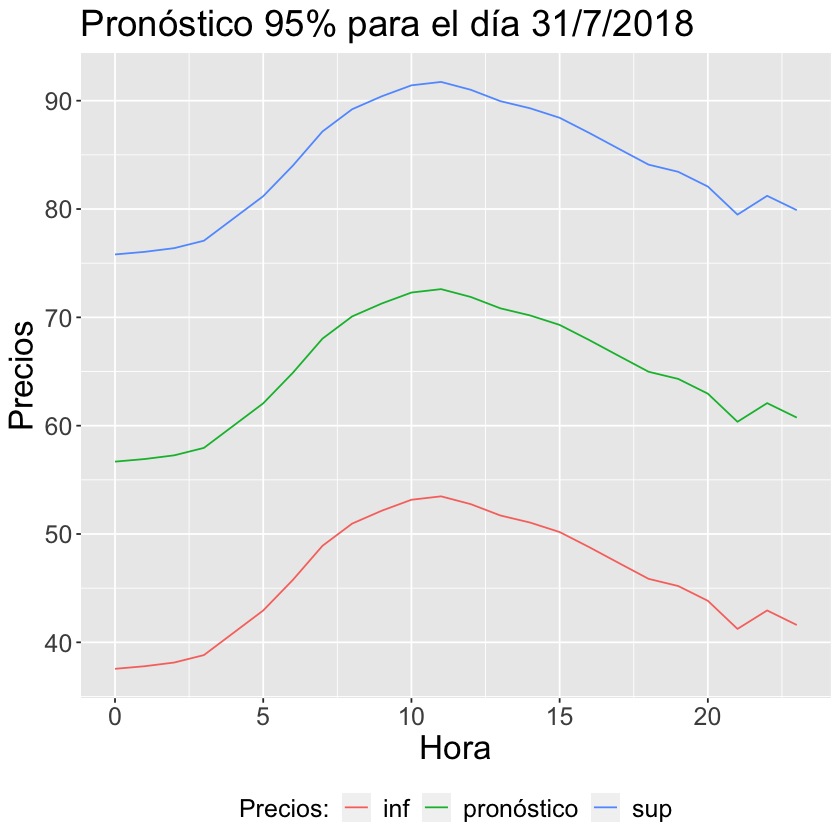

In [7]:
pron_horario <- predict(mod7,newdata=test7,level=0.95,int="p")   #Añade intervalo de predicción
#head(fore_hour)


#Arma el dataframe con los datos pronosticados
types <- c("precio"="real", "fit"="pronóstico","lwr"="inf","upr"="sup")
horas <- data.frame(hora=0:23)
pron.df <- cbind(horas,pron_horario)
#head(pron.df)
pron <- pron.df %>% tidyr::gather("type", "precios", 2:4) 
#head(pron)
plot.pronostico <- ggplot(pron,aes(hora,precios,group=type,color=types[type]))+
                     geom_line()+
                     labs(x = 'Hora', y = 'Precios',
                          title='Pronóstico 95% para el día 31/7/2018',
                          color="Precios:")+
                      mytheme
                 
plot.pronostico

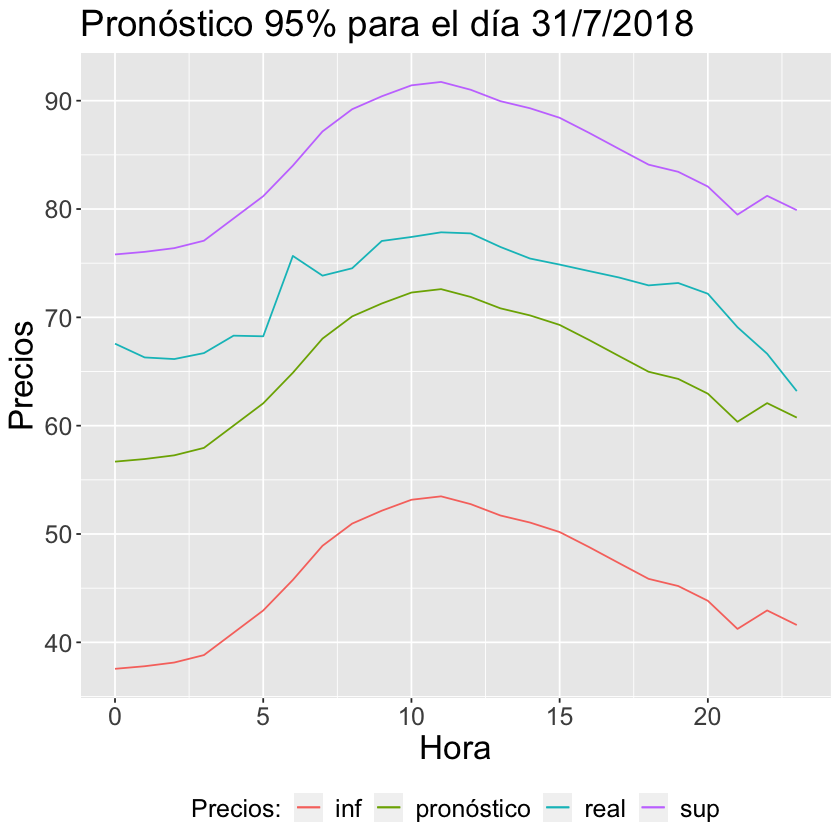

In [8]:
real.df <- cbind(horas,price7_test)
#head(real.df)
real <- real.df %>% tidyr::gather("type", "precios", 2) 
#head(real)
                 
plot.pronostico+geom_line(data=real,aes(hora,precios,color=types[type]))




## ¿Cómo utilizar la regresión para simular el precio?

### Hemos visto que podemos escribir $Y= a + bX_0 + \epsilon$, 
###  donde $\epsilon$ tiene distribución Normal con media 0 y desviación estandar=D.E. de los residuos.

### Luego, para simular el precio, basta "enchufar" los valores del las variables predictoras en la fórmula, y generar la muestra Normal correspondiente.

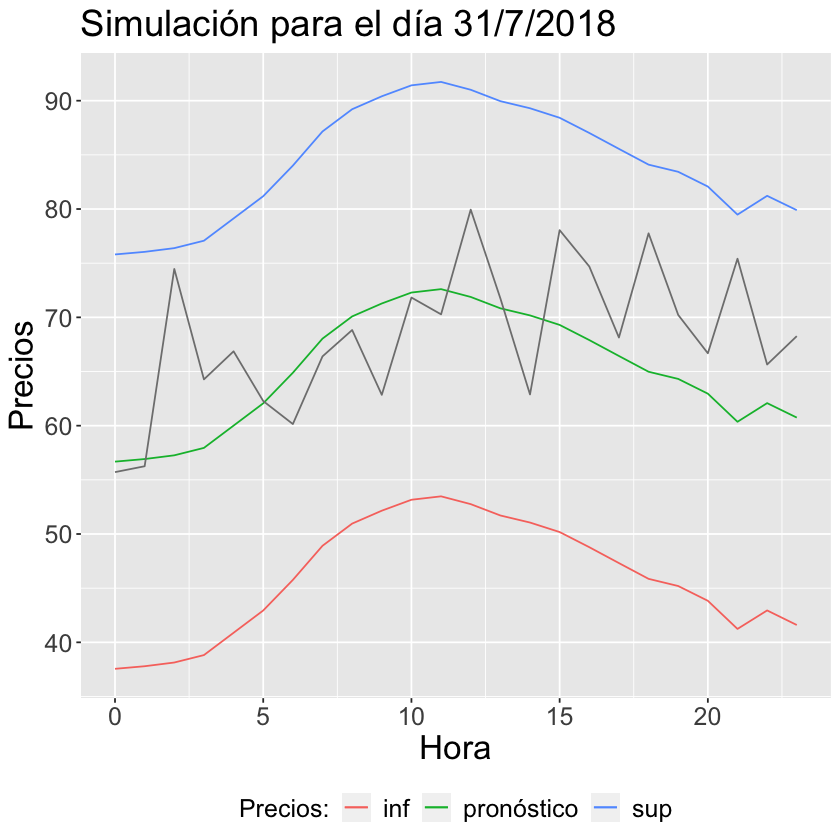

In [9]:
res7<-resid(mod7)

sim.df <- cbind(horas,sim=predict(mod7,newdata=test7) + rnorm(24,0,sd(res7)))
#head(sim.df)
sim <- sim.df %>% tidyr::gather("type", "precios", 2) 
#head(sim)
                
plot.pronostico+geom_line(data=sim,aes(hora,precios,color=types[type]))+
                         labs(title='Simulación para el día 31/7/2018')
                        
              

## ¿Podemos mejorar aún más el pronóstico y simulación?

### Veamos la evolución del precio durante los primeros 4 días de julio

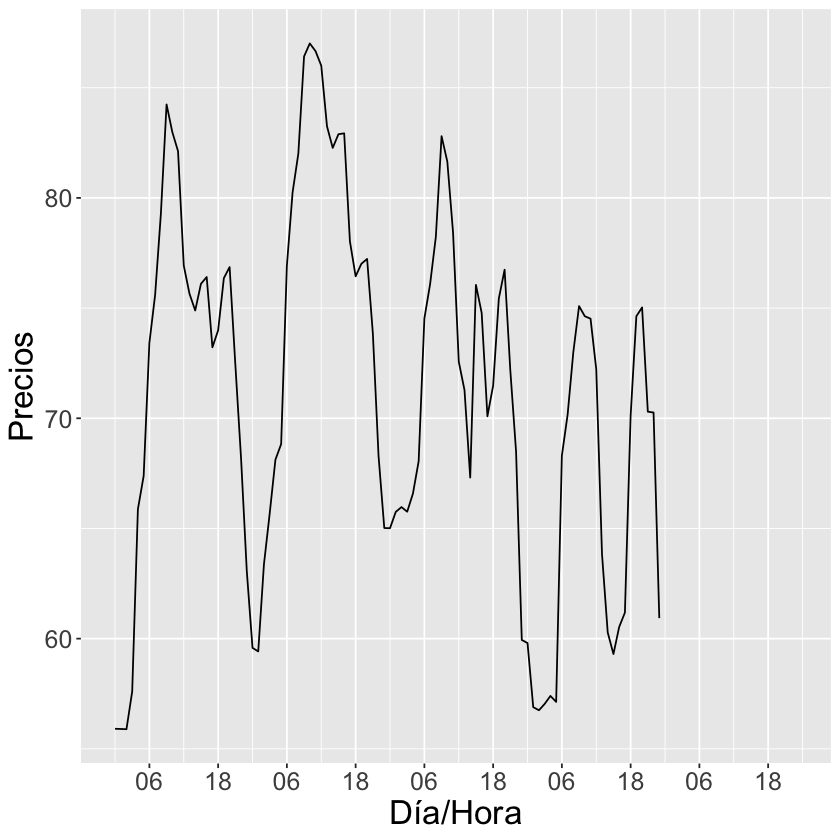

In [13]:
precio_hora <- data7[anio==2015 & dia<=5, .(time,precio)]
plot.hora <- precio_hora
plot.hora[97:120,2] <- NA  #esconde el 5to dia
plotfig <- ggplot(plot.hora,aes(time, precio))+
             geom_line(na.rm=TRUE)+
             scale_x_datetime(date_breaks="12 hours",date_labels = "%H")+
             mytheme+
             labs(x = 'Día/Hora', y = 'Precios')

plotfig

### ¿Cómo sigue la serie?

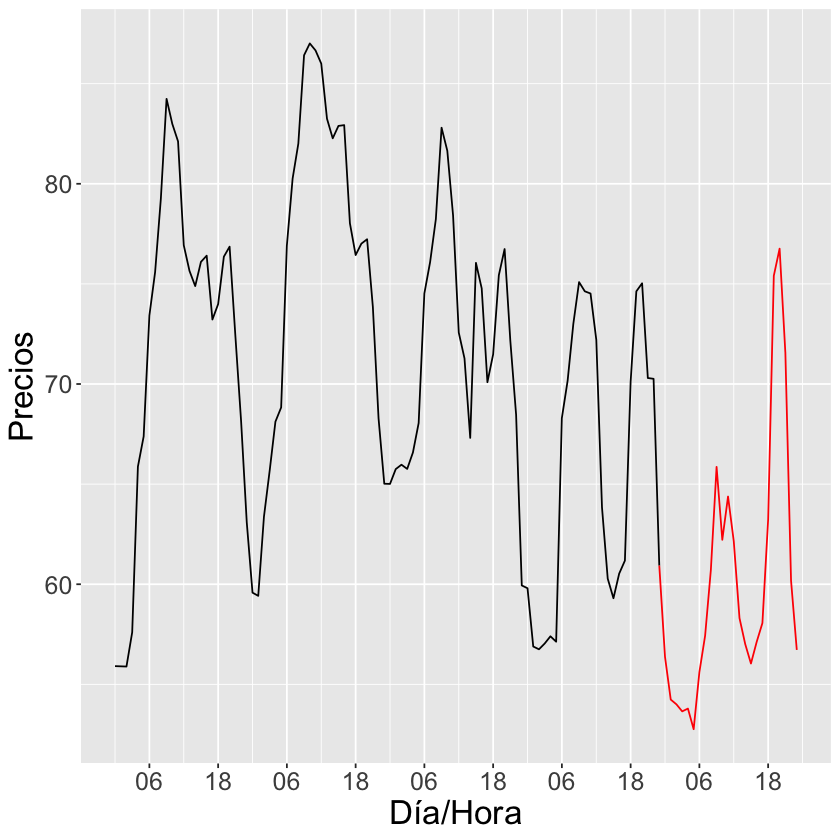

In [14]:
plot.hora <- precio_hora
plot.hora[-(96:120),2] <- NA  #muestra solo el 5to dia
plotfig+geom_line(data=plot.hora,na.rm=TRUE,color="red")

### El punto es que claramente los precios tienen un comportamiento *estacional*.

### Eso sugiere chequear la dependencia del precio respecto de precios anteriores.

### La función de *auto-correlación* hace justamente eso!

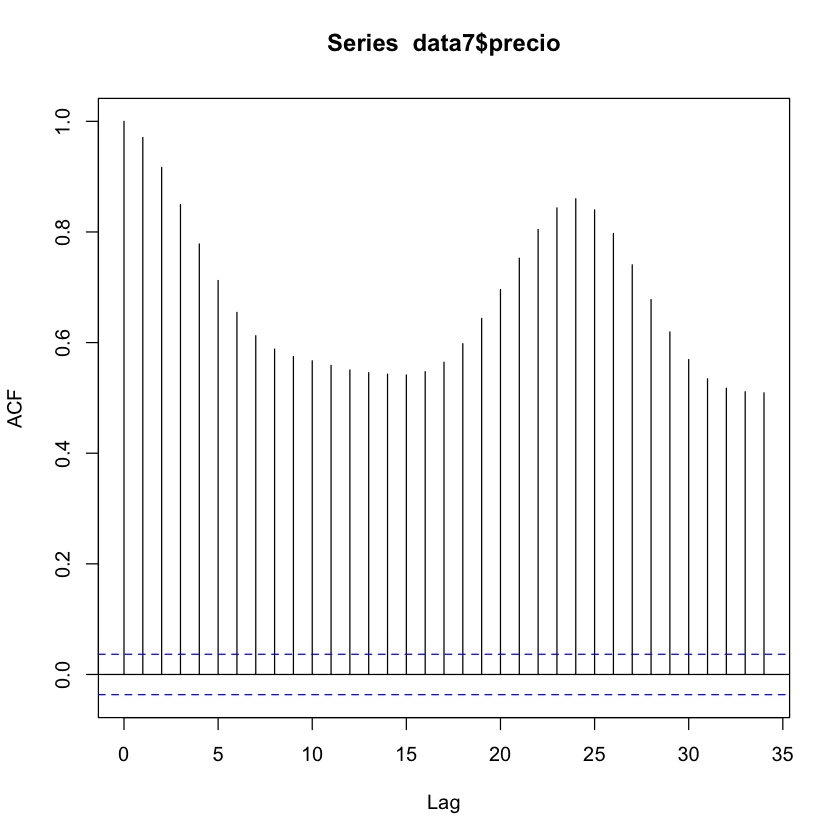

In [15]:
acf(data7$precio)

### Vemos que el precio es una *serie temporal*. Hay muchos modelos para series temporales.

### Por ejemplo, un modelo *auto-regresivo de orden $p$* (AR($p$)) se define como 

### $x_t - \mu = a_1 (x_{t-1} - \mu) +\ldots + a_p (x_{t-p} - \mu) + \epsilon_t$

### donde $\mu$  es la media del proceso y $\epsilon_t$ es el residuo en el periodo $t$.

### Calibremos un modelo AR($p$) a los precios de julio/2018.

In [16]:
price7_train <- data7[anio==2018,precio]
armod7<-ar(price7_train)
armod7


Call:
ar(x = price7_train)

Coefficients:
      1        2        3        4        5        6        7        8  
 1.1469  -0.1127  -0.0354  -0.1449   0.0646  -0.1034   0.0745   0.0449  
      9       10       11       12       13       14       15       16  
 0.0761  -0.0791  -0.0433  -0.0783   0.1014   0.0258  -0.0592   0.0115  
     17       18       19       20       21       22       23       24  
-0.0554   0.0411   0.0661  -0.0993   0.0790  -0.0146   0.0527   0.3399  
     25  
-0.3884  

Order selected 25  sigma^2 estimated as  1.711

### Analicemos los residuos. Antes que nada, es importante averiguar si el comportamiento de los residuos varía al largo del tiempo.

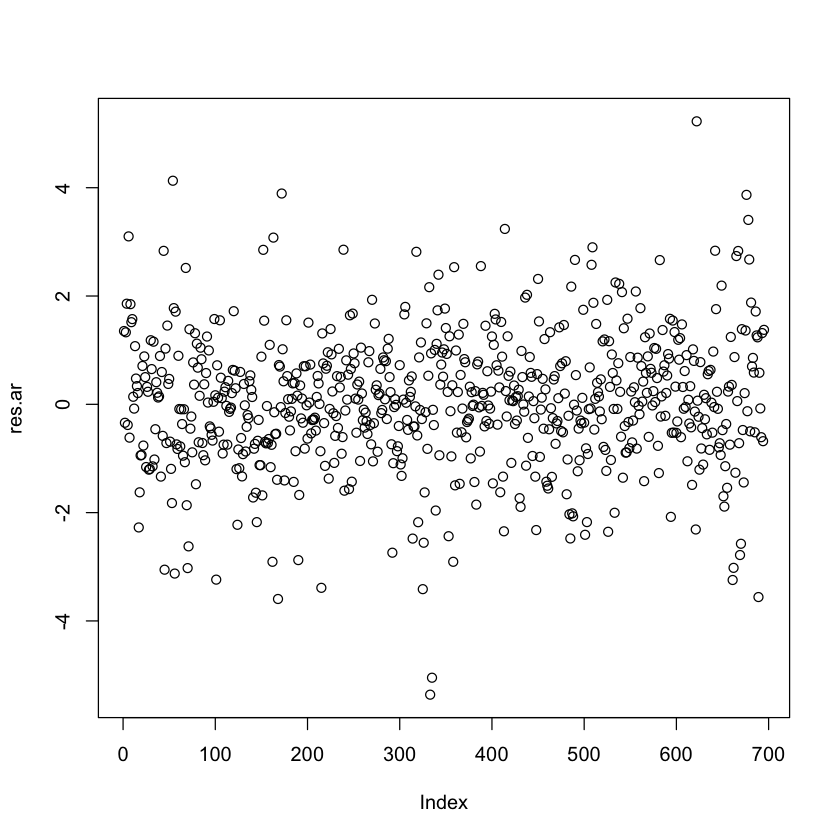

In [17]:
res.ar <- armod7$resid[-(1:armod7$order)]  #Se eliminan los primeros elementos ya que no tienen residuo
plot(res.ar)

### Se nota un comportamiento constante al largo del tiempo.

### También podemos chequear la auto-correlación de los residuos:

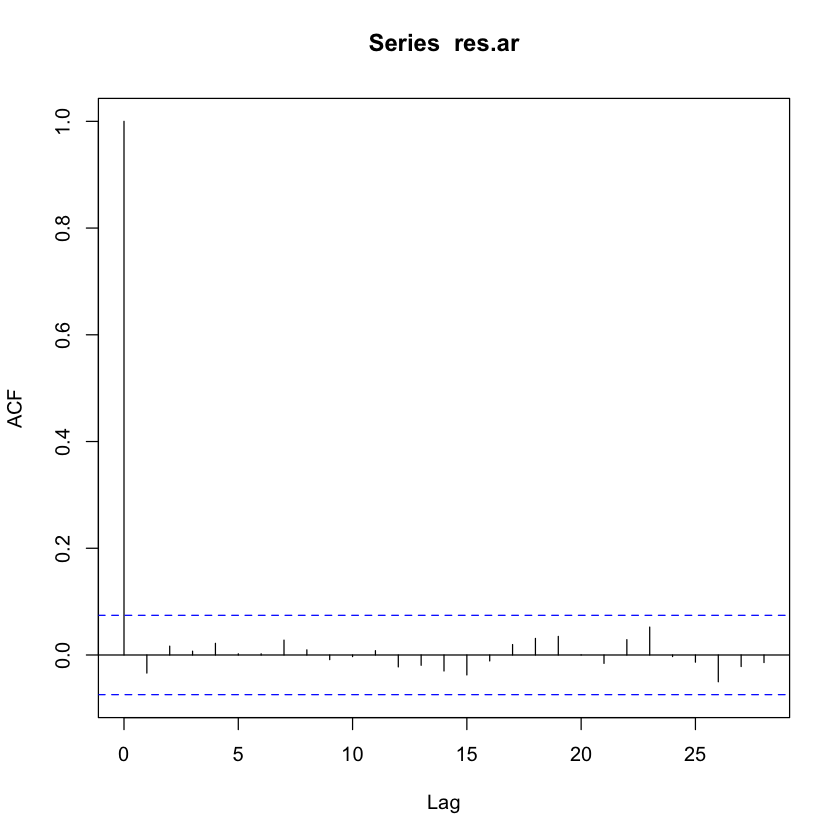

In [18]:
acf(res.ar)

### Los residuos no son correlacionados segun el análisis.

### Veamos como se distribuyen los residuos.

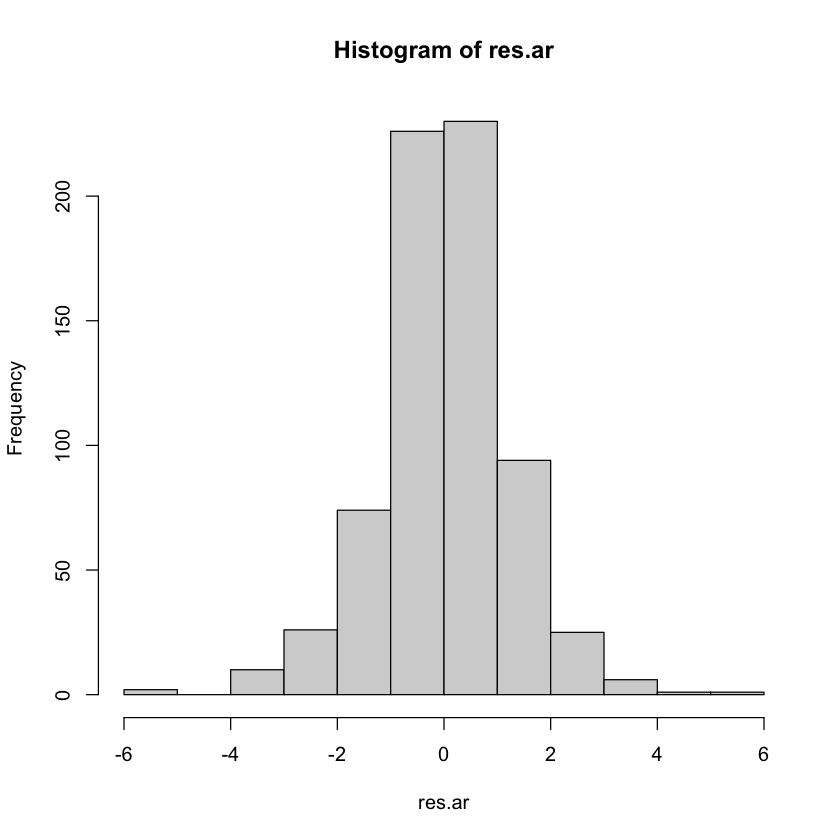

In [19]:
hist(res.ar)

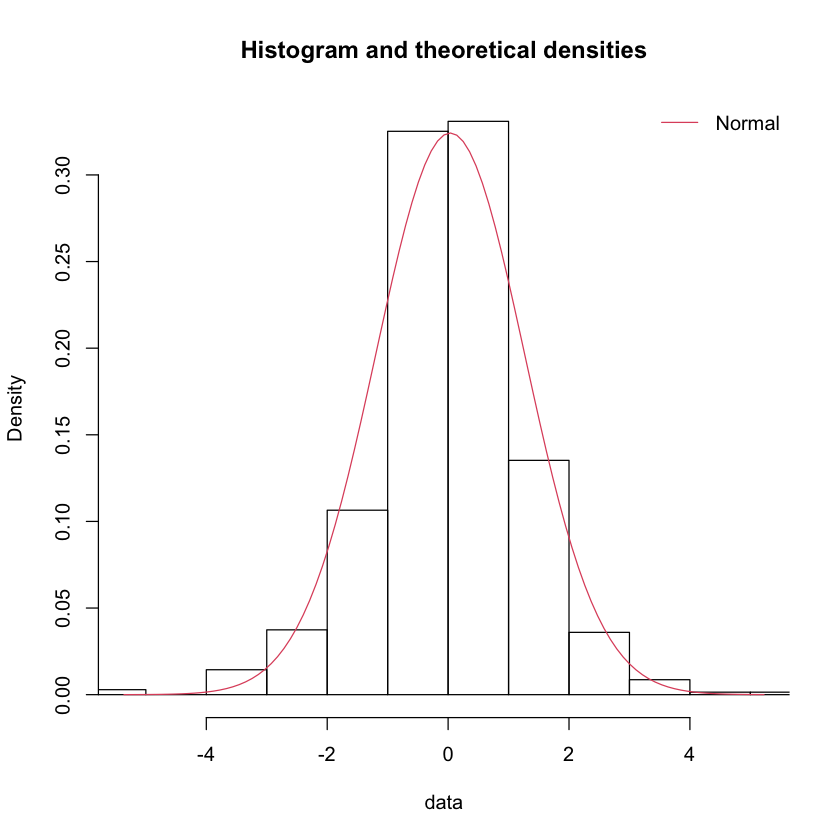

In [20]:
plot.legend <- "Normal"
a_norm <- fitdist(res.ar, "norm")
denscomp(a_norm,fitcol=2, legendtext=plot.legend)

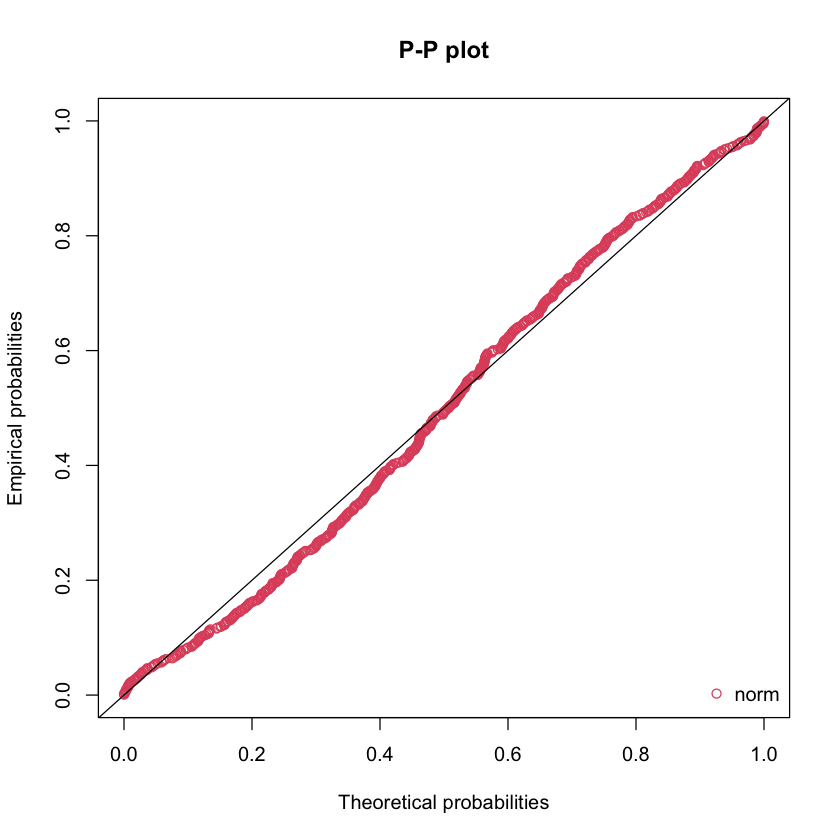

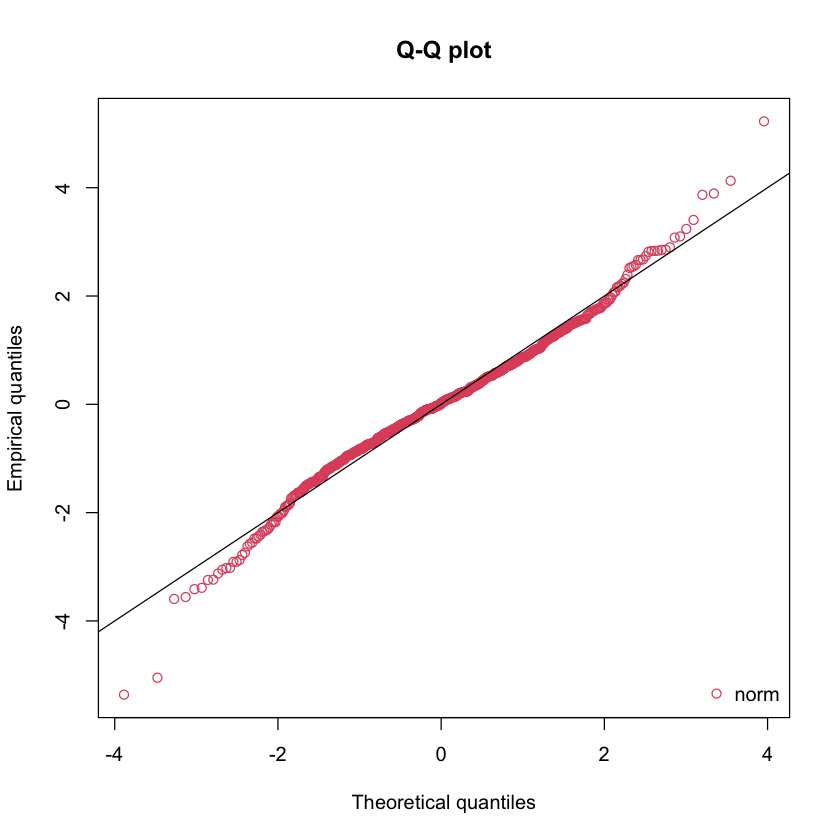

In [21]:
ppcomp(a_norm)
qqcomp(a_norm)

### Tal como anterioremente, al ajustar una Normal hay que tener cautela con las colas. 

### Ahora podemos hacer el pronóstico, de forma similar a lo que hicimos con el modelo de regresión.

In [22]:
pron_ar <- predict(armod7,n.ahead=24)   #n.ahead indica cuantos valores queremos predecir
cat(sprintf("Valores pronosticados\n\n"))
pron_ar$pred
cat(sprintf("\n\n"))
cat(sprintf("Errores estándar\n\n"))
pron_ar$se

Valores pronosticados



A Time Series:
 [1] 67.14568 65.68510 64.74618 65.08383 67.92278 69.41004 72.15089 73.69267
 [9] 73.95117 74.86090 74.38677 73.59711 72.36773 70.70158 69.92183 69.68075
[17] 69.34584 68.49483 69.09045 69.59182 69.51563 68.53706 66.55515 65.47302



Errores estándar



A Time Series:
 [1] 1.308208 1.990651 2.537391 2.993971 3.306275 3.531567 3.655278 3.722783
 [9] 3.765646 3.808177 3.849186 3.882729 3.898587 3.907316 3.912999 3.913960
[17] 3.913960 3.916179 3.920821 3.923291 3.928637 3.932630 3.934979 3.934997

### Veamos los resultados de modo gráfico

#### Para ello, utilizaremos la función *forecast*, que grafica las curvas correspondientes a pron_ar\\$pred $\pm$ 1.96*pron_ar\\$se

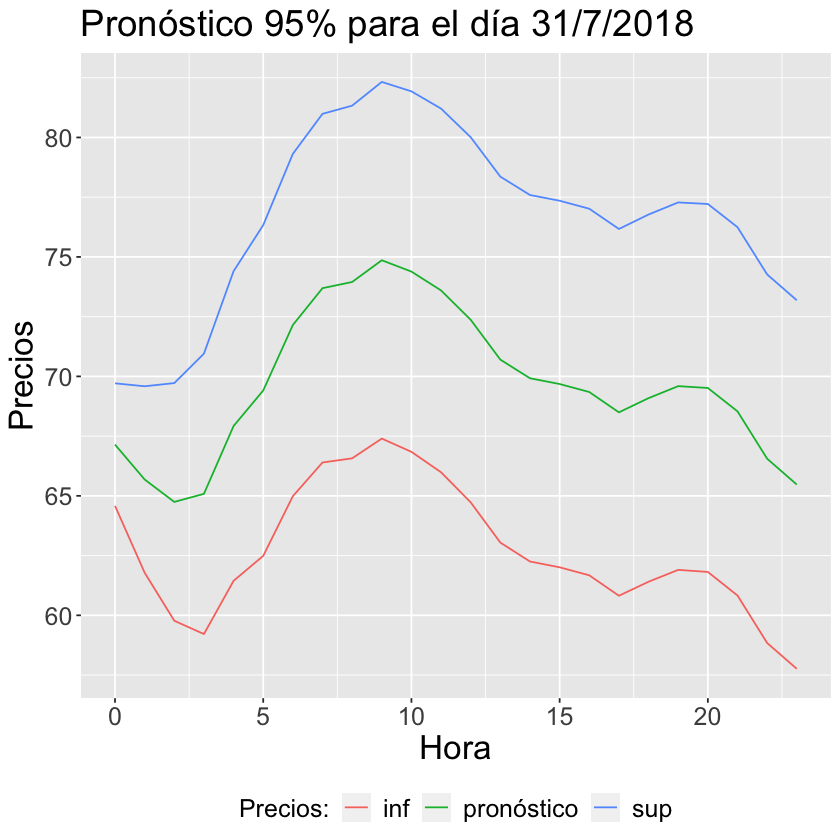

In [32]:
#install.packages('forecast')
library(forecast)
types <- c("pron.Point.Forecast"="pronóstico","pron.Lo.95"="inf","pron.Hi.95"="sup", "precio"="real", "sim"="sim")
horas <- data.frame(hora=0:23)

pron_ar_conf <- forecast(armod7,24,level=95)  #Level es el nivel de confianza (95%)

pron.ar.df <- data.frame(hora=horas,pron=pron_ar_conf)
#head(pron.ar.df)
pron.ar2 <- pron.ar.df %>% tidyr::gather("type", "precios", 2:4) 
#head(pron.ar2)
plot.pronostico <- ggplot(pron.ar2,aes(hora,precios,group=type,color=types[type]))+
                     geom_line()+
                     labs(x = 'Hora', y = 'Precios',
                          title='Pronóstico 95% para el día 31/7/2018',
                          color="Precios:")+
                     mytheme
                 
plot.pronostico


### ¿Como se compara el pronóstico con los valores reales?

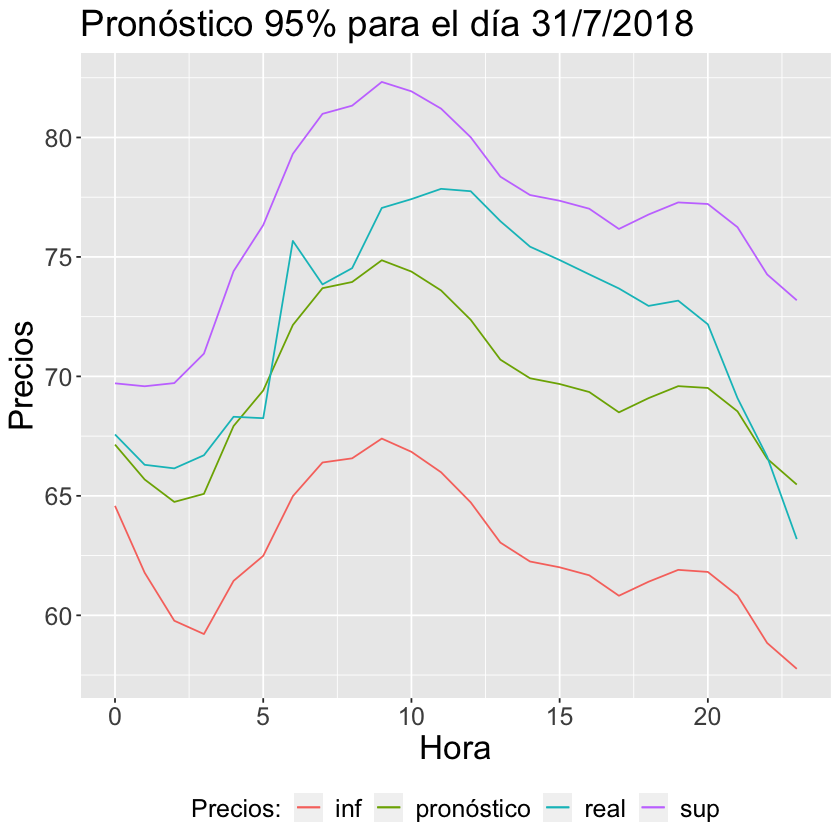

In [33]:
real.df <- cbind(horas,price7_test)
#head(real.df)
real <- real.df %>% tidyr::gather("type", "precios", 2) 
#head(real)
                 
plot.pronostico <- plot.pronostico+geom_line(data=real,aes(hora,precios,color=types[type]))

plot.pronostico

## OK, logramos hacer un buen pronóstico...pero el objetivo final es *simular* la serie de precios!

### ¿Cómo hacerlo? 

### Recordemos la ecuación del proceso auto-regresivo:

### $x_t - \mu = a_1 (x_{t-1} - \mu) +\ldots + a_p (x_{t-p} - \mu) + \epsilon_t$

### Ya hemos determinado que el residuo es Normal con media 0. La desviación estandar y los demás parametros salen del análisis del modelo AR:

In [28]:
m.ar <- armod7$x.mean
s.ar <- sqrt(armod7$var.pred)
p.ar <- armod7$order
cat("mean=", m.ar, "  sd=",s.ar, " order=",p.ar)

mean= 67.63732   sd= 1.308208  order= 25

In [29]:
cat("Coeficientes AR:")
coef <- as.numeric(armod7$ar)
coef

Coeficientes AR:

[1]  1.14693335 -0.11272353 -0.03538831 -0.14486886  0.06462284 -0.10341231
 [7]  0.07454435  0.04487785  0.07610046 -0.07914661 -0.04329509 -0.07834521
[13]  0.10141016  0.02577306 -0.05916836  0.01150564 -0.05543853  0.04106995
[19]  0.06610068 -0.09928616  0.07897688 -0.01458721  0.05267875  0.33988885
[25] -0.38843020

### ¿Cómo hacer la simulación?

In [30]:
sim.ar <- vector(mode="numeric",length=24)
ndata <- length(price7_train)
prev <- price7_train[ndata:(ndata-p.ar+1)]-m.ar
for (i in 1:24){
  sim.ar[i] <- m.ar + coef%*%prev + rnorm(1,0,s.ar)
  prev <- c(sim.ar[i]-m.ar,prev[-p.ar])
    }


### Veamos los resultados:

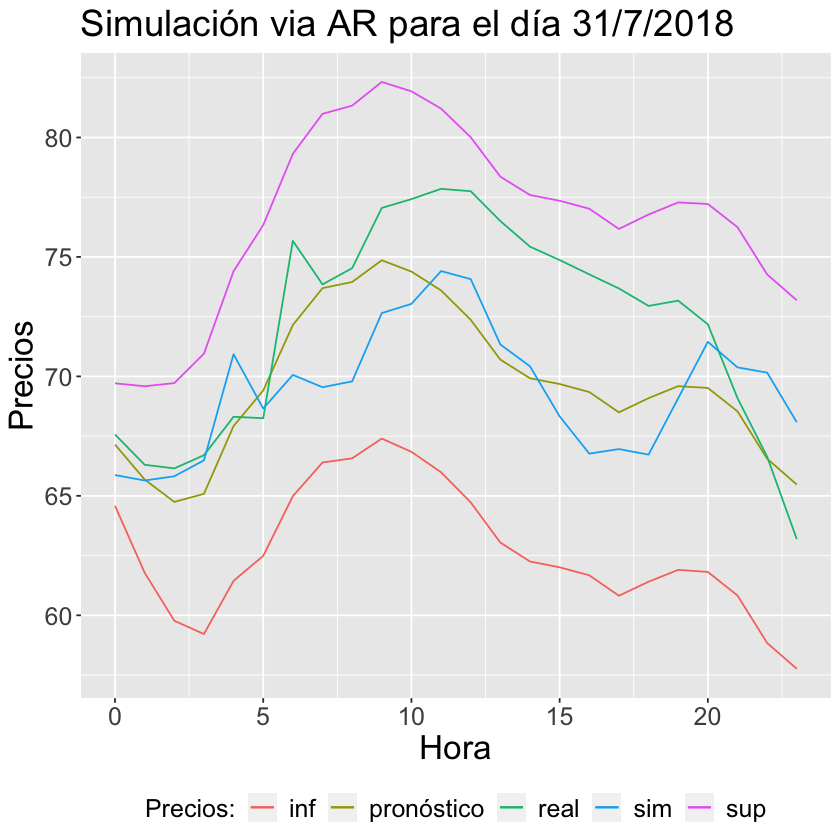

In [34]:
sim.df <- cbind(horas,sim=sim.ar)
#head(sim.df)
sim.plot <- sim.df %>% tidyr::gather("type", "precios", 2) 
#head(sim)
                
plot.pronostico+geom_line(data=sim.plot,aes(hora,precios,color=types[type]))+
                         labs(title='Simulación via AR para el día 31/7/2018')